In [1]:
%pip install pyspark

Note: you may need to restart the kernel to use updated packages.


In [2]:
from pyspark.sql import SparkSession


In [3]:
spark = SparkSession.builder \
    .appName("Netflix Analytics") \
    .getOrCreate()

In [4]:
credits_df = spark.read.csv("hdfs://localhost:9000/credits.csv", header=True, inferSchema=True)
titles_df = spark.read.csv("hdfs://localhost:9000/titles.csv", header=True, inferSchema=True)

credits_df.printSchema()
titles_df.printSchema()

root
 |-- person_id: integer (nullable = true)
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- character: string (nullable = true)
 |-- role: string (nullable = true)

root
 |-- id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- type: string (nullable = true)
 |-- description: string (nullable = true)
 |-- release_year: string (nullable = true)
 |-- age_certification: string (nullable = true)
 |-- runtime: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- production_countries: string (nullable = true)
 |-- seasons: string (nullable = true)
 |-- imdb_id: string (nullable = true)
 |-- imdb_score: string (nullable = true)
 |-- imdb_votes: string (nullable = true)
 |-- tmdb_popularity: string (nullable = true)
 |-- tmdb_score: string (nullable = true)



In [5]:
credits_df.show()


+---------+-------+------------------+--------------------+-----+
|person_id|     id|              name|           character| role|
+---------+-------+------------------+--------------------+-----+
|     3748|tm84618|    Robert De Niro|       Travis Bickle|ACTOR|
|    14658|tm84618|      Jodie Foster|       Iris Steensma|ACTOR|
|     7064|tm84618|     Albert Brooks|                 Tom|ACTOR|
|     3739|tm84618|     Harvey Keitel|Matthew 'Sport' H...|ACTOR|
|    48933|tm84618|   Cybill Shepherd|               Betsy|ACTOR|
|    32267|tm84618|       Peter Boyle|              Wizard|ACTOR|
|   519612|tm84618|    Leonard Harris|Senator Charles P...|ACTOR|
|    29068|tm84618|    Diahnne Abbott|     Concession Girl|ACTOR|
|   519613|tm84618|       Gino Ardito|  Policeman at Rally|ACTOR|
|     3308|tm84618|   Martin Scorsese|Passenger Watchin...|ACTOR|
|    43791|tm84618|     Murray Moston|   Iris' Time Keeper|ACTOR|
|   519614|tm84618|     Richard Higgs|Secret Service Agent|ACTOR|
|   519615

In [6]:
 titles_df.show(n=5, truncate=False, vertical=True)

-RECORD 0---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 id                   | ts300399                                                                                                                                                                                                                                                                                                                                                                                                                            
 title                | Five Came Back: The Reference Films                                                   

In [7]:
from pyspark.sql.functions import collect_list

grouped_df = credits_df.groupBy("id").agg(collect_list("name").alias("cast"))

transformed_credits_df = grouped_df.drop("role", "person_id", "character")

transformed_credits_df.show()

+---------+--------------------+
|       id|                cast|
+---------+--------------------+
|tm1000037|[Luna Wedler, Jan...|
|tm1000147|[Guy Pearce, Mati...|
| tm100015|[Idris Elba, Paul...|
|tm1000166|[Glenn Fredly, Ma...|
|tm1000185|[Adrianna Chlebic...|
| tm100027|[Dharmendra, Hema...|
|tm1000296|[Yang Tianxiang, ...|
|tm1000551|[Ini Dima-Okojie,...|
|tm1000599|[David Kopenawa Y...|
|tm1000619|[Prabhas, Pooja H...|
|tm1000797|[Kiko Mizuhara, H...|
| tm100106|[John Lloyd Cruz,...|
|tm1001095|[Rajkummar Rao, V...|
|tm1001097|[Gracie Marie Bra...|
|tm1001108|[The Notorious B....|
|tm1001267|[Valery Smekalov,...|
|tm1001619|[Roy Chiu, Tiffan...|
|tm1002408|[Maximilian Jabs,...|
|tm1002815|[Winslow Fegley, ...|
|tm1002869|[David Spade, Lon...|
+---------+--------------------+
only showing top 20 rows



In [8]:
df = transformed_credits_df.join(titles_df, transformed_credits_df.id == titles_df.id, 'inner').drop(titles_df.id)
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- cast: array (nullable = false)
 |    |-- element: string (containsNull = false)
 |-- title: string (nullable = true)
 |-- type: string (nullable = true)
 |-- description: string (nullable = true)
 |-- release_year: string (nullable = true)
 |-- age_certification: string (nullable = true)
 |-- runtime: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- production_countries: string (nullable = true)
 |-- seasons: string (nullable = true)
 |-- imdb_id: string (nullable = true)
 |-- imdb_score: string (nullable = true)
 |-- imdb_votes: string (nullable = true)
 |-- tmdb_popularity: string (nullable = true)
 |-- tmdb_score: string (nullable = true)



In [9]:
df.show(n=5, truncate=False, vertical=True)

-RECORD 0-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 id                   | tm1000037                                                                                                                                                                                                                                                                                                                                                                                                                                                     
 cast                 | [Luna Wedler, Jannis Niewöhner, Mi

In [10]:
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType, IntegerType

df = df.drop("imdb_id", "title_id", "person_id")

numerical_columns = ["imdb_score", "tmdb_popularity", "imdb_votes", "tmdb_score", "seasons", "runtime", "release_year"]
for column in numerical_columns:
    df = df.withColumn(column, col(column).cast(DoubleType()))

df.printSchema()

root
 |-- id: string (nullable = true)
 |-- cast: array (nullable = false)
 |    |-- element: string (containsNull = false)
 |-- title: string (nullable = true)
 |-- type: string (nullable = true)
 |-- description: string (nullable = true)
 |-- release_year: double (nullable = true)
 |-- age_certification: string (nullable = true)
 |-- runtime: double (nullable = true)
 |-- genres: string (nullable = true)
 |-- production_countries: string (nullable = true)
 |-- seasons: double (nullable = true)
 |-- imdb_score: double (nullable = true)
 |-- imdb_votes: double (nullable = true)
 |-- tmdb_popularity: double (nullable = true)
 |-- tmdb_score: double (nullable = true)



In [11]:
from pyspark.sql import functions as func

correlation_matrix = df.select([func.corr(column1, column2).alias(column1 + '_' + column2) for column1 in numerical_columns for column2 in numerical_columns]).toPandas()
correlation_matrix

,imdb_score_imdb_score,imdb_score_tmdb_popularity,imdb_score_imdb_votes,imdb_score_tmdb_score,imdb_score_seasons,imdb_score_runtime,imdb_score_release_year,tmdb_popularity_imdb_score,tmdb_popularity_tmdb_popularity,tmdb_popularity_imdb_votes,...,runtime_seasons,runtime_runtime,runtime_release_year,release_year_imdb_score,release_year_tmdb_popularity,release_year_imdb_votes,release_year_tmdb_score,release_year_seasons,release_year_runtime,release_year_release_year
0,1.0,0.000674,0.198263,0.013916,0.789325,-0.156005,-0.130835,0.000674,1.0,-0.005439,...,-0.15291,1.0,-0.184241,-0.130835,0.047886,-0.210153,0.032514,-0.548219,-0.184241,1.0


array([[<Axes: title={'center': 'release_year'}>,
        <Axes: title={'center': 'runtime'}>,
        <Axes: title={'center': 'seasons'}>],
       [<Axes: title={'center': 'imdb_score'}>,
        <Axes: title={'center': 'imdb_votes'}>,
        <Axes: title={'center': 'tmdb_popularity'}>],
       [<Axes: title={'center': 'tmdb_score'}>, <Axes: >, <Axes: >]],
      dtype=object)

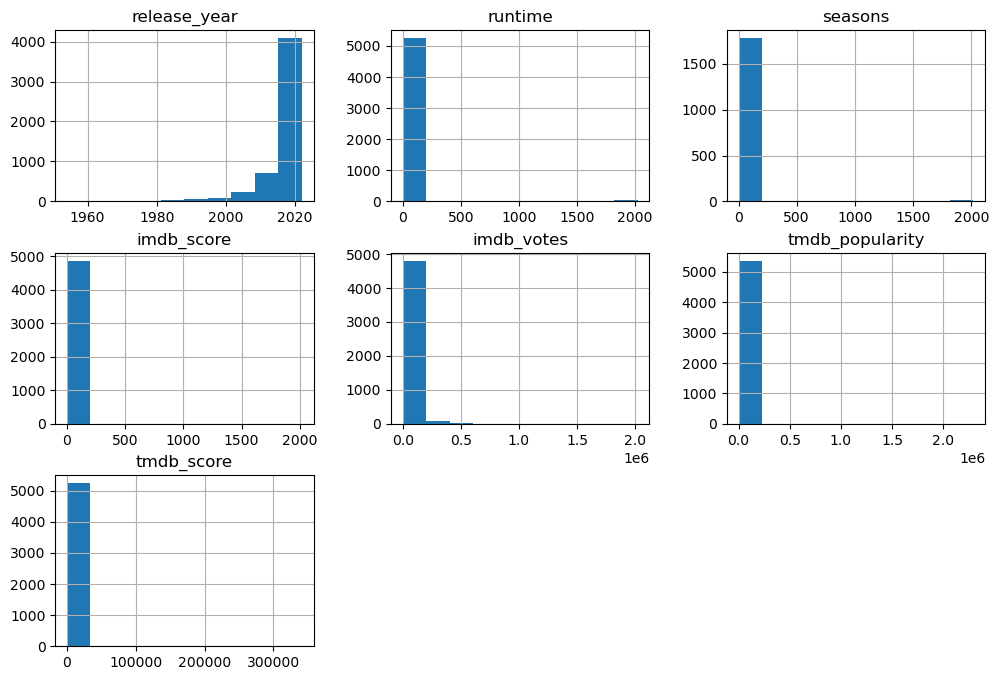

In [12]:
numerical_columns = ["release_year", "runtime", "seasons", "imdb_score", "imdb_votes", "tmdb_popularity", "tmdb_score"]
df.select(numerical_columns).toPandas().hist(figsize=(12, 8))


<Axes: >

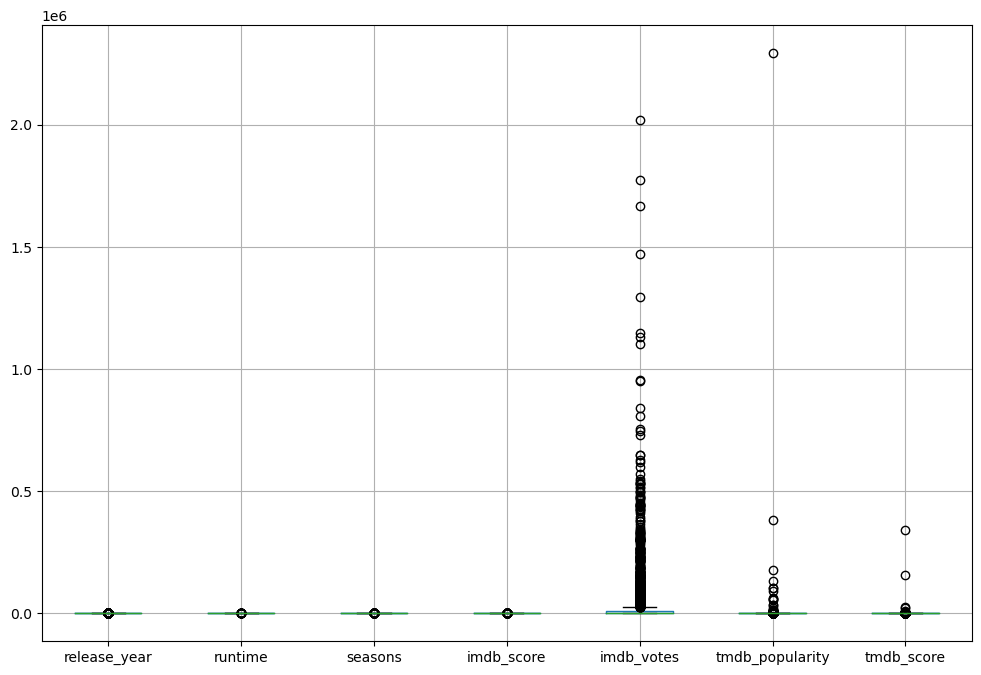

In [13]:
df.select(numerical_columns).toPandas().boxplot(figsize=(12, 8))


In [14]:
lower_bound = 0  
upper_bound = 100  


filtered_df = df.filter((col("tmdb_popularity") >= lower_bound) & (col("tmdb_popularity") <= upper_bound))

df.show()

+---------+--------------------+--------------------+-----+--------------------+------------+-----------------+-------+--------------------+--------------------+-------+----------+----------+---------------+----------+
|       id|                cast|               title| type|         description|release_year|age_certification|runtime|              genres|production_countries|seasons|imdb_score|imdb_votes|tmdb_popularity|tmdb_score|
+---------+--------------------+--------------------+-----+--------------------+------------+-----------------+-------+--------------------+--------------------+-------+----------+----------+---------------+----------+
|tm1000037|[Luna Wedler, Jan...|        Je suis Karl|MOVIE|After most of her...|      2021.0|                R|  126.0|['drama', 'thrill...|        ['CZ', 'DE']|   NULL|       5.4|    1077.0|         12.981|       5.5|
|tm1000147|[Guy Pearce, Mati...|            Zone 414|MOVIE|In the near futur...|      2021.0|                R|   98.0|['sci

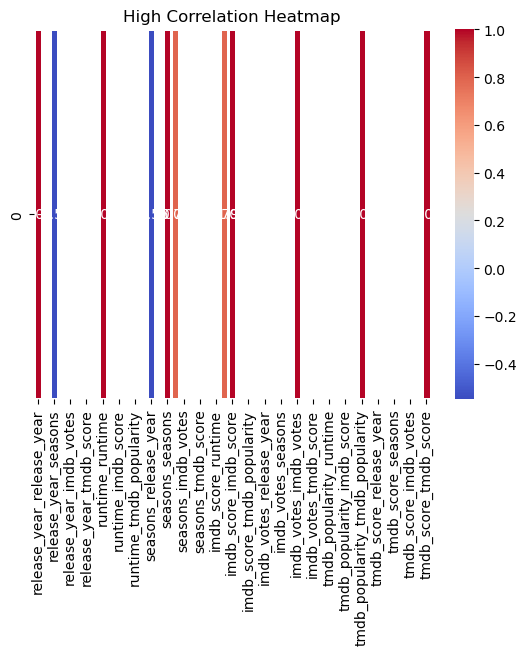

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

numerical_columns = ["release_year", "runtime", "seasons", "imdb_score", "imdb_votes", "tmdb_popularity", "tmdb_score"]
correlation_matrix = df.select([func.corr(column1, column2).alias(column1 + '_' + column2) for column1 in numerical_columns for column2 in numerical_columns]).toPandas()
threshold = 0.3  
high_correlation = correlation_matrix[abs(correlation_matrix) > threshold]
sns.heatmap(high_correlation, annot=True, cmap="coolwarm", fmt=".2f", linewidths=1)
plt.title("High Correlation Heatmap")
plt.show()


In [16]:
df = df.drop("imdb_votes", "tmdb_popularity")
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- cast: array (nullable = false)
 |    |-- element: string (containsNull = false)
 |-- title: string (nullable = true)
 |-- type: string (nullable = true)
 |-- description: string (nullable = true)
 |-- release_year: double (nullable = true)
 |-- age_certification: string (nullable = true)
 |-- runtime: double (nullable = true)
 |-- genres: string (nullable = true)
 |-- production_countries: string (nullable = true)
 |-- seasons: double (nullable = true)
 |-- imdb_score: double (nullable = true)
 |-- tmdb_score: double (nullable = true)



In [17]:
df.show(n=30, truncate=False, vertical=True)

-RECORD 0--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 id                   

In [18]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- cast: array (nullable = false)
 |    |-- element: string (containsNull = false)
 |-- title: string (nullable = true)
 |-- type: string (nullable = true)
 |-- description: string (nullable = true)
 |-- release_year: double (nullable = true)
 |-- age_certification: string (nullable = true)
 |-- runtime: double (nullable = true)
 |-- genres: string (nullable = true)
 |-- production_countries: string (nullable = true)
 |-- seasons: double (nullable = true)
 |-- imdb_score: double (nullable = true)
 |-- tmdb_score: double (nullable = true)



In [24]:
from pyspark.sql.functions import concat_ws


df = df.withColumn("cast", concat_ws(",", col("cast")))


df.write.csv("db_pyspark.csv")


In [25]:

from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from sklearn.metrics.pairwise import cosine_similarity


string_indexer = StringIndexer(inputCol="genres", outputCol="genre_index", handleInvalid="skip")


one_hot_encoder = OneHotEncoder(inputCol="genre_index", outputCol="genre_vector")

pipeline = Pipeline(stages=[string_indexer, one_hot_encoder])
transformed_df = pipeline.fit(df).transform(df)

assembler = VectorAssembler(inputCols=["genre_vector", "imdb_score", "runtime", "tmdb_score", "seasons"],
                            outputCol="features", handleInvalid="skip")

transformed_df = assembler.transform(transformed_df)

scaler = StandardScaler(inputCol="features", outputCol="norm_features", withStd=True, withMean=True)
scaler_model = scaler.fit(transformed_df)
transformed_df = scaler_model.transform(transformed_df)

pandas_df = transformed_df.toPandas()

# Check if any rows match the title "Takers"
if not pandas_df.empty and "Medical Police" in pandas_df["title"].values:
    # Access the first row with the title "Takers"
    target_item = pandas_df[pandas_df["title"] == "Medical Police"]["norm_features"].values[0]
    similarities = cosine_similarity([target_item], pandas_df["norm_features"].tolist())[0]
    pandas_df["similarity"] = similarities
    sorted_df = pandas_df.sort_values(by="similarity", ascending=False)
    top_similar_items = sorted_df.head(4)
    print(top_similar_items[["title", "similarity"]])
else:
    print("No shows found with that title")


                     title  similarity
2           Medical Police    1.000000
4     Merry Happy Whatever    0.994736
509               The Crew    0.989239
1544       The Pentaverate    0.986068
